<a href="https://colab.research.google.com/github/FernandoRizo/BioKnee/blob/main/U_Net_BioKnee_Actualizada.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Segmentación automatica con U-Net**

In [ ]:
!pip install pynrrd

Montar el drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Librerías y preprocesamiento

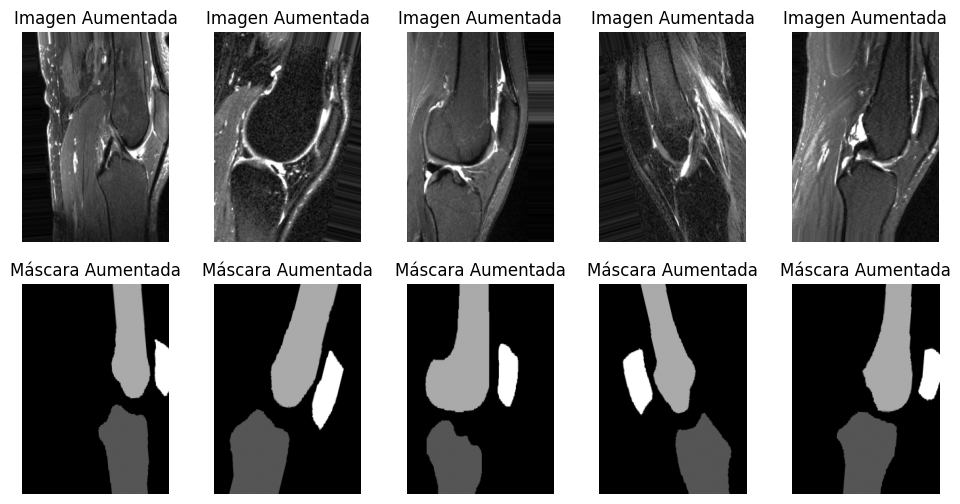

In [ ]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from sklearn.model_selection import train_test_split
from google.colab import drive
import cv2  # Para redimensionar imágenes .nrrd
import nrrd  # Para cargar archivos .nrrd

# ================================
# Parámetros y directorios para rótula
# ================================
# Directorios de imágenes y máscaras
image_dir = '/content/drive/MyDrive/Equipo Trifuerza/Datos/Data set grises/Dataset mezclado 2D'
mask_dir  = '/content/drive/MyDrive/Equipo Trifuerza/Datos/Data set grises/Mascaras mezcladas'

# Parámetros de la imagen y segmentación
IMG_HEIGHT = 320
IMG_WIDTH = 224
IMG_CHANNELS = 1      # Imágenes en escala de grises
NUM_CLASSES = 4       # Ejemplo: Rótula, tibia, fémur, fondo
batch_size = 8

# Filtrar archivos válidos (.nrrd y .bmp)
valid_extensions = ('.nrrd', '.bmp')
image_files = sorted([f for f in os.listdir(image_dir) if f.lower().endswith(valid_extensions)])
mask_files  = sorted([f for f in os.listdir(mask_dir) if f.lower().endswith(valid_extensions)])
assert len(image_files) == len(mask_files), "La cantidad de imágenes y máscaras debe ser la misma"

# ================================
# Función personalizada para cargar imágenes
# ================================
def load_image_custom(filepath, target_size=(IMG_HEIGHT, IMG_WIDTH), color_mode='grayscale'):
    ext = os.path.splitext(filepath)[1].lower()
    if ext == '.nrrd':
        # Cargar usando la librería nrrd
        img_data, header = nrrd.read(filepath)
        # Dependiendo del color_mode, procesamos la imagen:
        if color_mode == 'grayscale':
            # Si la imagen es a color, convertirla a escala de grises (promediando canales)
            if img_data.ndim == 3 and img_data.shape[-1] > 1:
                img_data = np.mean(img_data, axis=-1)
            # Asegurarse de que la imagen sea 2D antes de redimensionar
            # Redimensionar usando cv2 (cv2.resize requiere (ancho, alto))
            img_resized = cv2.resize(img_data, (target_size[1], target_size[0]))
            # Agregar la dimensión del canal
            img_resized = np.expand_dims(img_resized, axis=-1)
            return img_resized
        elif color_mode == 'rgb':
            # Si es color, se espera que la imagen tenga 3 canales
            # En caso de tener una sola banda, se replicará
            if img_data.ndim == 2:
                img_data = np.stack((img_data,)*3, axis=-1)
            img_resized = cv2.resize(img_data, (target_size[1], target_size[0]))
            return img_resized
        else:
            raise ValueError("Modo de color no soportado: " + color_mode)
    else:
        # Para otros formatos (.bmp), usamos load_img de Keras
        return img_to_array(load_img(filepath, target_size=target_size, color_mode=color_mode))

# ================================
# Cargar y preprocesar imágenes y máscaras
# ================================
images = []
masks = []

for img_file, msk_file in zip(image_files, mask_files):
    image_path = os.path.join(image_dir, img_file)
    mask_path  = os.path.join(mask_dir, msk_file)

    # Cargar la imagen y normalizar (valores entre 0 y 1)
    img = load_image_custom(image_path, target_size=(IMG_HEIGHT, IMG_WIDTH), color_mode='grayscale')
    img = img.astype('float32') / 255.0

    # Cargar la máscara (se espera que contenga índices de clase)
    mask = load_image_custom(mask_path, target_size=(IMG_HEIGHT, IMG_WIDTH), color_mode='grayscale')
    mask = mask.astype(np.int64)
    #Rotar la máscara 90 grados a la izquierda
    mask = np.rot90(mask, k=3, axes=(0, 1))  # 90° horario
    # Redimensiona la máscara para que tenga nuevamente el tamaño
    mask = cv2.resize(mask, (IMG_WIDTH, IMG_HEIGHT), interpolation=cv2.INTER_NEAREST) # → (H, W, 1)
    # VOLTEO HORIZONTAL para corregir el “espejo”
    mask = np.fliplr(mask)
    # Aseguramos (H, W, 1)
    # mask = np.expand_dims(mask, axis=-1) comentada por problema de dimensiones
    # Agragar la dimensión del canal para que la máscara tenga forma(alto,ancho,1)
    mask = np.expand_dims(mask, axis=-1)
    images.append(img)
    masks.append(mask)

# Convertir listas a arrays de NumPy
images = np.array(images)
masks  = np.array(masks)      # → (N, 320,224,1,1)

# Dividir en conjuntos de entrenamiento y validación (por ejemplo, 90% train, 10% val)
images_train, images_val, masks_train, masks_val = train_test_split(
    images, masks, test_size=0.1, random_state=42
)


# ================================
# Crear generadores de datos con aumento (augmentation)
# ================================
data_gen_args = dict(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# 2) Generadores
image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen  = ImageDataGenerator(**data_gen_args)

seed = 42
# — Ajuste no estrictamente necesario, pero útil si algún escalador lo requiere
image_datagen.fit(images_train, augment=True, seed=seed)
mask_datagen.fit(masks_train,  augment=True, seed=seed)

train_img_gen = image_datagen.flow(images_train,
                                   batch_size=batch_size,
                                   seed=seed)
train_mask_gen = mask_datagen.flow(masks_train,
                                   batch_size=batch_size,
                                   seed=seed)

def train_generator():
    while True:
        imgs = next(train_img_gen)
        msks = next(train_mask_gen)
        yield imgs, msks


# (Opcional) Visualizar algunas imágenes y máscaras aumentadas
batch = next(train_generator())
plt.figure(figsize=(12, 6))
for i in range(5):
    plt.subplot(2, 5, i+1)
    plt.imshow(batch[0][i].squeeze(), cmap='gray')
    plt.title("Imagen Aumentada")
    plt.axis('off')
    plt.subplot(2, 5, i+6)
    plt.imshow(batch[1][i].squeeze(), cmap='gray')
    plt.title("Máscara Aumentada")
    plt.axis('off')
plt.show()

Definición U-Net multiclase y entrenamiento

Epoch 1/45
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 570ms/step - accuracy: 0.5590 - loss: 1.3069
Epoch 1: val_loss improved from inf to 0.90748, saving model to /content/drive/MyDrive/Equipo Trifuerza/Modelos entrenados/Checkpoint/Save_Unet_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.5631 - loss: 1.2991 - val_accuracy: 0.6979 - val_loss: 0.9075
Epoch 2/45
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step - accuracy: 0.6914 - loss: 0.8738
Epoch 2: val_loss improved from 0.90748 to 0.84401, saving model to /content/drive/MyDrive/Equipo Trifuerza/Modelos entrenados/Checkpoint/Save_Unet_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 10s 451ms/step - accuracy: 0.6915 - loss: 0.8737 - val_accuracy: 0.6979 - val_loss: 0.8440
Epoch 3/45
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step - accuracy: 0.7020 - loss: 0.8088
Epoch 3: val_loss improved from 0.84401 to 0.79771, saving model to /content/drive/MyDrive/Equipo Trifuerza/Modelos entrenados/Checkpoint/Save_Unet_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 432ms/step - accuracy: 0.7018 - loss: 0.8090 - val_accuracy: 0.6979 - val_loss: 0.7977
Epoch 4/45
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step - accuracy: 0.6880 - loss: 0.8199
Epoch 4: val_loss improved from 0.79771 to 0.77569, saving model to /content/drive/MyDrive/Equipo Trifuerza/Modelos entrenados/Checkpoint/Save_Unet_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 414ms/step - accuracy: 0.6882 - loss: 0.8189 - val_accuracy: 0.6979 - val_loss: 0.7757
Epoch 5/45
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step - accuracy: 0.6991 - loss: 0.7659
Epoch 5: val_loss improved from 0.77569 to 0.76766, saving model to /content/drive/MyDrive/Equipo Trifuerza/Modelos entrenados/Checkpoint/Save_Unet_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 432ms/step - accuracy: 0.6990 - loss: 0.7660 - val_accuracy: 0.6979 - val_loss: 0.7677
Epoch 6/45
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step - accuracy: 0.6909 - loss: 0.7709
Epoch 6: val_loss improved from 0.76766 to 0.74511, saving model to /content/drive/MyDrive/Equipo Trifuerza/Modelos entrenados/Checkpoint/Save_Unet_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 419ms/step - accuracy: 0.6910 - loss: 0.7704 - val_accuracy: 0.6979 - val_loss: 0.7451
Epoch 7/45
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step - accuracy: 0.6990 - loss: 0.7341
Epoch 7: val_loss improved from 0.74511 to 0.68063, saving model to /content/drive/MyDrive/Equipo Trifuerza/Modelos entrenados/Checkpoint/Save_Unet_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 10s 445ms/step - accuracy: 0.6989 - loss: 0.7338 - val_accuracy: 0.6979 - val_loss: 0.6806
Epoch 8/45
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step - accuracy: 0.6958 - loss: 0.7027
Epoch 8: val_loss improved from 0.68063 to 0.66371, saving model to /content/drive/MyDrive/Equipo Trifuerza/Modelos entrenados/Checkpoint/Save_Unet_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 10s 461ms/step - accuracy: 0.6959 - loss: 0.7029 - val_accuracy: 0.7256 - val_loss: 0.6637
Epoch 9/45
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step - accuracy: 0.7200 - loss: 0.6890
Epoch 9: val_loss improved from 0.66371 to 0.61551, saving model to /content/drive/MyDrive/Equipo Trifuerza/Modelos entrenados/Checkpoint/Save_Unet_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 10s 447ms/step - accuracy: 0.7202 - loss: 0.6887 - val_accuracy: 0.7589 - val_loss: 0.6155
Epoch 10/45
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step - accuracy: 0.7381 - loss: 0.6627
Epoch 10: val_loss improved from 0.61551 to 0.58116, saving model to /content/drive/MyDrive/Equipo Trifuerza/Modelos entrenados/Checkpoint/Save_Unet_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 428ms/step - accuracy: 0.7385 - loss: 0.6618 - val_accuracy: 0.7711 - val_loss: 0.5812
Epoch 11/45
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step - accuracy: 0.7587 - loss: 0.5867
Epoch 11: val_loss improved from 0.58116 to 0.52079, saving model to /content/drive/MyDrive/Equipo Trifuerza/Modelos entrenados/Checkpoint/Save_Unet_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 10s 444ms/step - accuracy: 0.7590 - loss: 0.5865 - val_accuracy: 0.8034 - val_loss: 0.5208
Epoch 12/45
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step - accuracy: 0.7781 - loss: 0.5606
Epoch 12: val_loss did not improve from 0.52079
22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 406ms/step - accuracy: 0.7781 - loss: 0.5603 - val_accuracy: 0.7945 - val_loss: 0.5256
Epoch 13/45
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step - accuracy: 0.7856 - loss: 0.5374
Epoch 13: val_loss improved from 0.52079 to 0.44870, saving model to /content/drive/MyDrive/Equipo Trifuerza/Modelos entrenados/Checkpoint/Save_Unet_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 10s 449ms/step - accuracy: 0.7861 - loss: 0.5364 - val_accuracy: 0.8407 - val_loss: 0.4487
Epoch 14/45
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step - accuracy: 0.8115 - loss: 0.4842
Epoch 14: val_loss improved from 0.44870 to 0.43110, saving model to /content/drive/MyDrive/Equipo Trifuerza/Modelos entrenados/Checkpoint/Save_Unet_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 427ms/step - accuracy: 0.8117 - loss: 0.4841 - val_accuracy: 0.8600 - val_loss: 0.4311
Epoch 15/45
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step - accuracy: 0.8329 - loss: 0.4533
Epoch 15: val_loss did not improve from 0.43110
22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 422ms/step - accuracy: 0.8329 - loss: 0.4532 - val_accuracy: 0.8538 - val_loss: 0.4347
Epoch 16/45
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step - accuracy: 0.8537 - loss: 0.4099
Epoch 16: val_loss improved from 0.43110 to 0.36726, saving model to /content/drive/MyDrive/Equipo Trifuerza/Modelos entrenados/Checkpoint/Save_Unet_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 11s 490ms/step - accuracy: 0.8538 - loss: 0.4094 - val_accuracy: 0.8699 - val_loss: 0.3673
Epoch 17/45
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step - accuracy: 0.8562 - loss: 0.4022
Epoch 17: val_loss improved from 0.36726 to 0.32776, saving model to /content/drive/MyDrive/Equipo Trifuerza/Modelos entrenados/Checkpoint/Save_Unet_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 427ms/step - accuracy: 0.8564 - loss: 0.4015 - val_accuracy: 0.8894 - val_loss: 0.3278
Epoch 18/45
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step - accuracy: 0.8662 - loss: 0.3675
Epoch 18: val_loss did not improve from 0.32776
22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 428ms/step - accuracy: 0.8663 - loss: 0.3672 - val_accuracy: 0.8500 - val_loss: 0.4272
Epoch 19/45
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step - accuracy: 0.8616 - loss: 0.3753
Epoch 19: val_loss did not improve from 0.32776
22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 410ms/step - accuracy: 0.8621 - loss: 0.3742 - val_accuracy: 0.8803 - val_loss: 0.3678
Epoch 20/45
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step - accuracy: 0.8636 - loss: 0.3855
Epoch 20: val_loss improved from 0.32776 to 0.32747, saving model to /content/drive/MyDrive/Equipo Trifuerza/Modelos entrenados/Checkpoint/Save_Unet_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 11s 485ms/step - accuracy: 0.8637 - loss: 0.3850 - val_accuracy: 0.8905 - val_loss: 0.3275
Epoch 21/45
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step - accuracy: 0.8835 - loss: 0.3335
Epoch 21: val_loss did not improve from 0.32747
22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 406ms/step - accuracy: 0.8834 - loss: 0.3335 - val_accuracy: 0.8819 - val_loss: 0.3478
Epoch 22/45
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step - accuracy: 0.8780 - loss: 0.3346
Epoch 22: val_loss did not improve from 0.32747
22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 421ms/step - accuracy: 0.8780 - loss: 0.3346 - val_accuracy: 0.8863 - val_loss: 0.3311
Epoch 23/45
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step - accuracy: 0.8733 - loss: 0.3458
Epoch 23: val_loss improved from 0.32747 to 0.29429, saving model to /content/drive/MyDrive/Equipo Trifuerza/Modelos entrenados/Checkpoint/Save_Unet_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 11s 505ms/step - accuracy: 0.8738 - loss: 0.3445 - val_accuracy: 0.9010 - val_loss: 0.2943
Epoch 24/45
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step - accuracy: 0.8862 - loss: 0.3195
Epoch 24: val_loss did not improve from 0.29429
22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 418ms/step - accuracy: 0.8864 - loss: 0.3190 - val_accuracy: 0.8934 - val_loss: 0.3089
Epoch 25/45
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step - accuracy: 0.8932 - loss: 0.2980
Epoch 25: val_loss improved from 0.29429 to 0.26214, saving model to /content/drive/MyDrive/Equipo Trifuerza/Modelos entrenados/Checkpoint/Save_Unet_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 11s 491ms/step - accuracy: 0.8933 - loss: 0.2978 - val_accuracy: 0.9144 - val_loss: 0.2621
Epoch 26/45
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step - accuracy: 0.8972 - loss: 0.2884
Epoch 26: val_loss did not improve from 0.26214
22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 431ms/step - accuracy: 0.8973 - loss: 0.2881 - val_accuracy: 0.9124 - val_loss: 0.2681
Epoch 27/45
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step - accuracy: 0.9027 - loss: 0.2737
Epoch 27: val_loss did not improve from 0.26214
22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 412ms/step - accuracy: 0.9027 - loss: 0.2736 - val_accuracy: 0.9112 - val_loss: 0.2715
Epoch 28/45
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step - accuracy: 0.8968 - loss: 0.2945
Epoch 28: val_loss did not improve from 0.26214
22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 410ms/step - accuracy: 0.8969 - loss: 0.2940 - val_accuracy: 0.9114 - val_loss: 0.2678
Epoch 29/45
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step - accuracy: 0.9013 - loss: 0.2716
Epoch 29: val_loss improved from 0.2621

22/22 ━━━━━━━━━━━━━━━━━━━━ 11s 485ms/step - accuracy: 0.9014 - loss: 0.2714 - val_accuracy: 0.9186 - val_loss: 0.2465
Epoch 30/45
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step - accuracy: 0.9119 - loss: 0.2499
Epoch 30: val_loss did not improve from 0.24647
22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 419ms/step - accuracy: 0.9118 - loss: 0.2502 - val_accuracy: 0.9168 - val_loss: 0.2561
Epoch 31/45
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step - accuracy: 0.8985 - loss: 0.2753
Epoch 31: val_loss did not improve from 0.24647
22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 426ms/step - accuracy: 0.8987 - loss: 0.2751 - val_accuracy: 0.9161 - val_loss: 0.2557
Epoch 32/45
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step - accuracy: 0.9159 - loss: 0.2381
Epoch 32: val_loss did not improve from 0.24647
22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 408ms/step - accuracy: 0.9158 - loss: 0.2384 - val_accuracy: 0.9167 - val_loss: 0.2515
Epoch 33/45
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step - accuracy: 0.9001 - loss: 0.2763
Epoch 33: val_loss improved from 0.2464

22/22 ━━━━━━━━━━━━━━━━━━━━ 12s 531ms/step - accuracy: 0.9003 - loss: 0.2759 - val_accuracy: 0.9229 - val_loss: 0.2375
Epoch 34/45
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step - accuracy: 0.9201 - loss: 0.2223
Epoch 34: val_loss did not improve from 0.23753
22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 408ms/step - accuracy: 0.9199 - loss: 0.2227 - val_accuracy: 0.9198 - val_loss: 0.2433
Epoch 35/45
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step - accuracy: 0.9165 - loss: 0.2350
Epoch 35: val_loss did not improve from 0.23753
22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 410ms/step - accuracy: 0.9167 - loss: 0.2346 - val_accuracy: 0.9127 - val_loss: 0.2753
Epoch 36/45
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step - accuracy: 0.9007 - loss: 0.2818
Epoch 36: val_loss did not improve from 0.23753
22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 410ms/step - accuracy: 0.9010 - loss: 0.2810 - val_accuracy: 0.9177 - val_loss: 0.2696
Epoch 37/45
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step - accuracy: 0.9095 - loss: 0.2587
Epoch 37: val_loss did not improve from

22/22 ━━━━━━━━━━━━━━━━━━━━ 11s 491ms/step - accuracy: 0.9183 - loss: 0.2359 - val_accuracy: 0.9231 - val_loss: 0.2375
Epoch 39/45
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step - accuracy: 0.9131 - loss: 0.2493
Epoch 39: val_loss did not improve from 0.23751
22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 421ms/step - accuracy: 0.9134 - loss: 0.2483 - val_accuracy: 0.9210 - val_loss: 0.2465
Epoch 40/45
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step - accuracy: 0.9178 - loss: 0.2317
Epoch 40: val_loss did not improve from 0.23751
22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 422ms/step - accuracy: 0.9177 - loss: 0.2322 - val_accuracy: 0.9223 - val_loss: 0.2445
Epoch 41/45
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step - accuracy: 0.9091 - loss: 0.2571
Epoch 41: val_loss improved from 0.23751 to 0.22791, saving model to /content/drive/MyDrive/Equipo Trifuerza/Modelos entrenados/Checkpoint/Save_Unet_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 11s 502ms/step - accuracy: 0.9093 - loss: 0.2566 - val_accuracy: 0.9259 - val_loss: 0.2279
Epoch 42/45
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step - accuracy: 0.9249 - loss: 0.2127
Epoch 42: val_loss did not improve from 0.22791
22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 406ms/step - accuracy: 0.9248 - loss: 0.2130 - val_accuracy: 0.9133 - val_loss: 0.2780
Epoch 43/45
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step - accuracy: 0.9125 - loss: 0.2416
Epoch 43: val_loss did not improve from 0.22791
22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 424ms/step - accuracy: 0.9124 - loss: 0.2421 - val_accuracy: 0.9255 - val_loss: 0.2463
Epoch 44/45
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step - accuracy: 0.9297 - loss: 0.2017
Epoch 44: val_loss did not improve from 0.22791
22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 423ms/step - accuracy: 0.9296 - loss: 0.2018 - val_accuracy: 0.9172 - val_loss: 0.2496
Epoch 45/45
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step - accuracy: 0.9108 - loss: 0.2560
Epoch 45: val_loss did not improve from

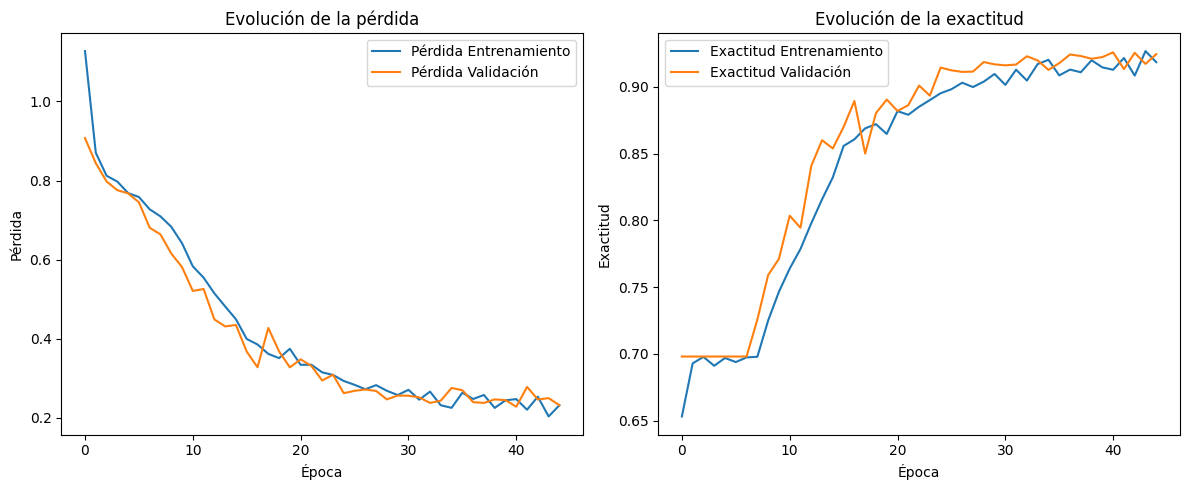

In [ ]:
# Definir la U-Net para segmentación multi‑clase
# ================================
from tensorflow.keras import layers, models, optimizers

def U_net(input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), num_classes=NUM_CLASSES):
    inputs = tf.keras.Input(shape=input_shape)

    # Bloque Down 1
    conv1 = layers.Conv2D(64, 3, padding='same', activation='relu')(inputs)
    conv1 = layers.Conv2D(64, 3, padding='same', activation='relu')(conv1)
    #conv1 = layers.Dropout(0.3)(conv1)            # 30% de neuronas apaga
    pool1 = layers.MaxPooling2D((2, 2))(conv1)

    # Bloque Down 2
    conv2 = layers.Conv2D(128, 3, padding='same', activation='relu')(pool1)
    conv2 = layers.Conv2D(128, 3, padding='same', activation='relu')(conv2)
    #conv2 = layers.Dropout(0.3)(conv2)            # 30% de neuronas apaga
    pool2 = layers.MaxPooling2D((2, 2))(conv2)

    # Bloque Down 3
    conv3 = layers.Conv2D(256, 3, padding='same', activation='relu')(pool2)
    conv3 = layers.Conv2D(256, 3, padding='same', activation='relu')(conv3)
    pool3 = layers.MaxPooling2D((2, 2))(conv3)

    # Bloque intermedio
    conv4 = layers.Conv2D(512, 3, padding='same', activation='relu')(pool3)
    conv4 = layers.Conv2D(512, 3, padding='same', activation='relu')(conv4)

    # Up 1
    up1 = layers.UpSampling2D((2, 2))(conv4)
    concat1 = layers.concatenate([up1, conv3])
    conv5 = layers.Conv2D(256, 3, padding='same', activation='relu')(concat1)
    conv5 = layers.Conv2D(256, 3, padding='same', activation='relu')(conv5)

    # Up 2
    up2 = layers.UpSampling2D((2, 2))(conv5)
    concat2 = layers.concatenate([up2, conv2])
    conv6 = layers.Conv2D(128, 3, padding='same', activation='relu')(concat2)
    conv6 = layers.Conv2D(128, 3, padding='same', activation='relu')(conv6)

    # Up 3
    up3 = layers.UpSampling2D((2, 2))(conv6)
    concat3 = layers.concatenate([up3, conv1])
    conv7 = layers.Conv2D(64, 3, padding='same', activation='relu')(concat3)
    conv7 = layers.Conv2D(64, 3, padding='same', activation='relu')(conv7)

    # Capa de salida: NUM_CLASSES canales con activación softmax
    outputs = layers.Conv2D(num_classes, 1, activation='softmax')(conv7)

    model = models.Model(inputs, outputs)
    return model

model = U_net()
model.compile(optimizer=optimizers.Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

steps_per_epoch = len(images_train) // batch_size
validation_steps = len(images_val) // batch_size

# ================================
# Entrenamiento
# ================================

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

checkpoint_path = '/content/drive/MyDrive/Equipo Trifuerza/Modelos entrenados/Checkpoint/Save_Unet_model.h5'
checkpoint_cb = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_loss',        # métrica a monitorear
    save_best_only=True,       # guarda sólo cuando mejora
    save_weights_only=False,   # guarda todo el modelo (arquitectura + pesos)
    mode='auto',               # 'min' para pérdidas, 'max' para métricas como accuracy
    verbose=1                  # imprime mensaje cuando guarda
)

# EarlyStopping
early_stop = EarlyStopping(
    monitor='val_loss',         # Monitorea la pérdida en validación
    patience=5,                 # Número de épocas sin mejora antes de detener el entrenamiento
    restore_best_weights=True   # Restaura los mejores pesos obtenidos durante el entrenamiento
)

# 3) Opcional: validación SIN augmentación
#    simplemente pasamos los arrays puros
val_data = (images_val, masks_val)
# Entrenamiento del modelo con EarlyStopping

history = model.fit(
    train_generator(),
    steps_per_epoch = len(images_train) // batch_size,
    epochs           = 45,
    validation_data  = val_data,
    validation_steps = None,          # al usar tuplas, no es necesario
    callbacks        = [checkpoint_cb, early_stop]
)

"""history = model.fit(
    images_train,
    masks_train,
    train_generator(),
    batch_size=batch_size,
    steps_per_epoch=steps_per_epoch,
    validation_data=(images_val, masks_val),
    validation_data=val_generator(),
    validation_steps=validation_steps,
    epochs=45,                 # Número máximo de épocas
    #callbacks=[early_stop]     # Añadido el callback aquí
)"""

# Guardar el modelo entrenado
# Ruta personalizada en Drive
model_path = '/content/drive/MyDrive/Equipo Trifuerza/Códigos fuentes/Modelos entrenados/U-Net_entrenada_DA_45e_GPU.h5'
model.save(model_path)

# ================================
# Graficar curvas de entrenamiento
# ================================
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Pérdida Entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida Validación')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.title('Evolución de la pérdida')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Exactitud Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Exactitud Validación')
plt.xlabel('Época')
plt.ylabel('Exactitud')
plt.title('Evolución de la exactitud')
plt.legend()
plt.tight_layout()
plt.show()



### Visualización mascaras automáticas

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 805ms/step
Shapes → preds_classes: (4, 320, 224)  true_classes: (4, 320, 224)


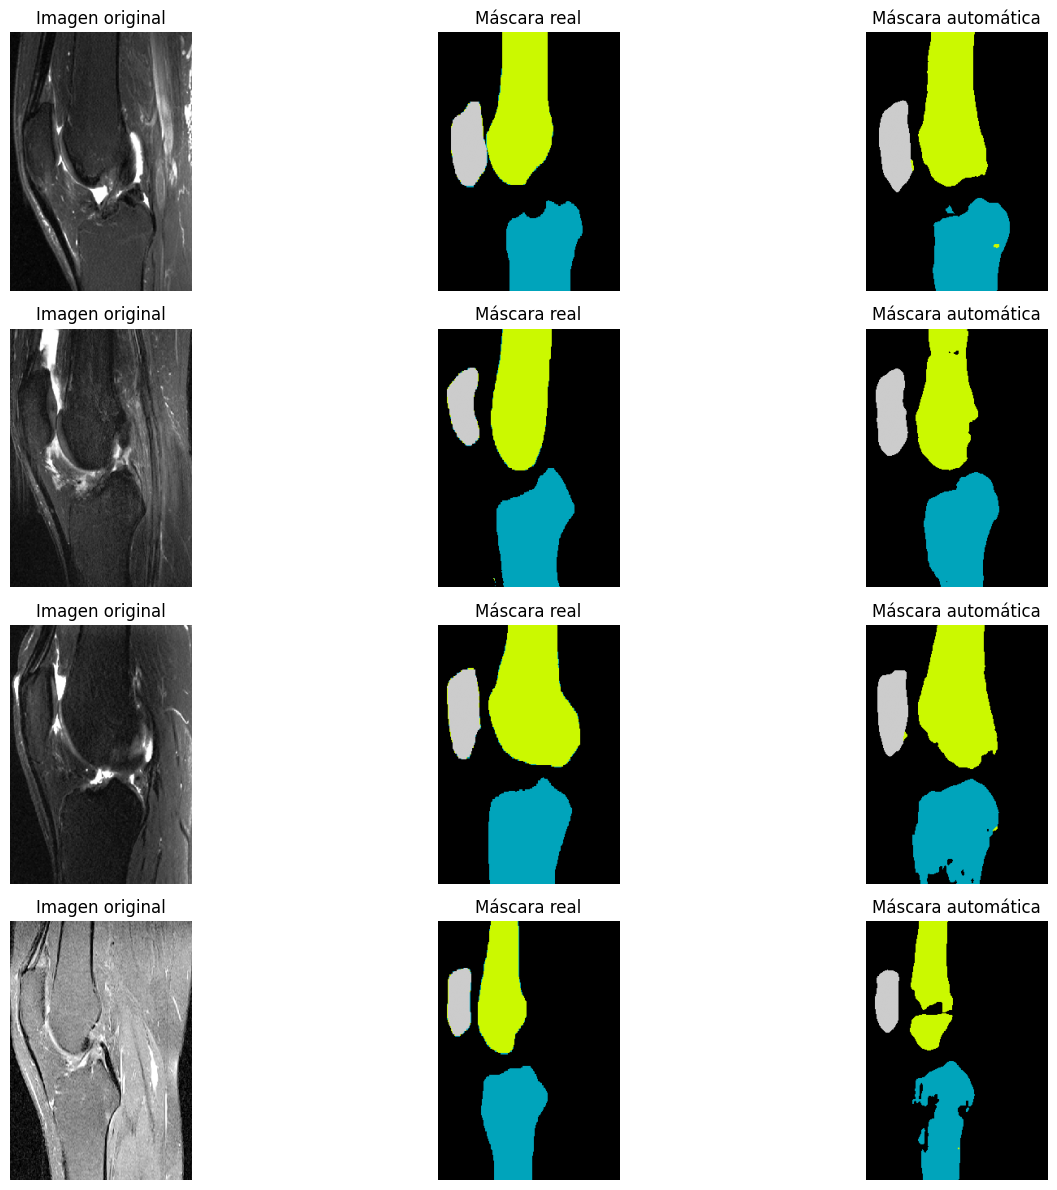

In [ ]:
# Elegir muestras
num_samples   = 4
sample_images = images_val[:num_samples]
sample_masks  = masks_val[:num_samples]

# Predicciones
preds = model.predict(sample_images)
preds_classes = np.argmax(preds, axis=-1)

# Quitar cualquier dimensión extra
true_classes = np.squeeze(sample_masks)

print("Shapes → preds_classes:", preds_classes.shape,
      " true_classes:", true_classes.shape)
#   Deben coincidir en (5, 320, 224)

# Visualización
plt.figure(figsize=(15, num_samples * 3))
for i in range(num_samples):
    # Original
    plt.subplot(num_samples, 3, i*3 + 1)
    plt.imshow(sample_images[i].squeeze(), cmap='gray')
    plt.title('Imagen original'); plt.axis('off')
    # Máscara real
    plt.subplot(num_samples, 3, i*3 + 2)
    plt.imshow(true_classes[i], cmap='nipy_spectral',
               vmin=0, vmax=NUM_CLASSES-1)
    plt.title('Máscara real'); plt.axis('off')
    # Máscara predicha
    plt.subplot(num_samples, 3, i*3 + 3)
    plt.imshow(preds_classes[i], cmap='nipy_spectral',
               vmin=0, vmax=NUM_CLASSES-1)
    plt.title('Máscara automática'); plt.axis('off')

plt.tight_layout()
plt.show()


##Suavizar contorno de la mascara


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 781ms/step


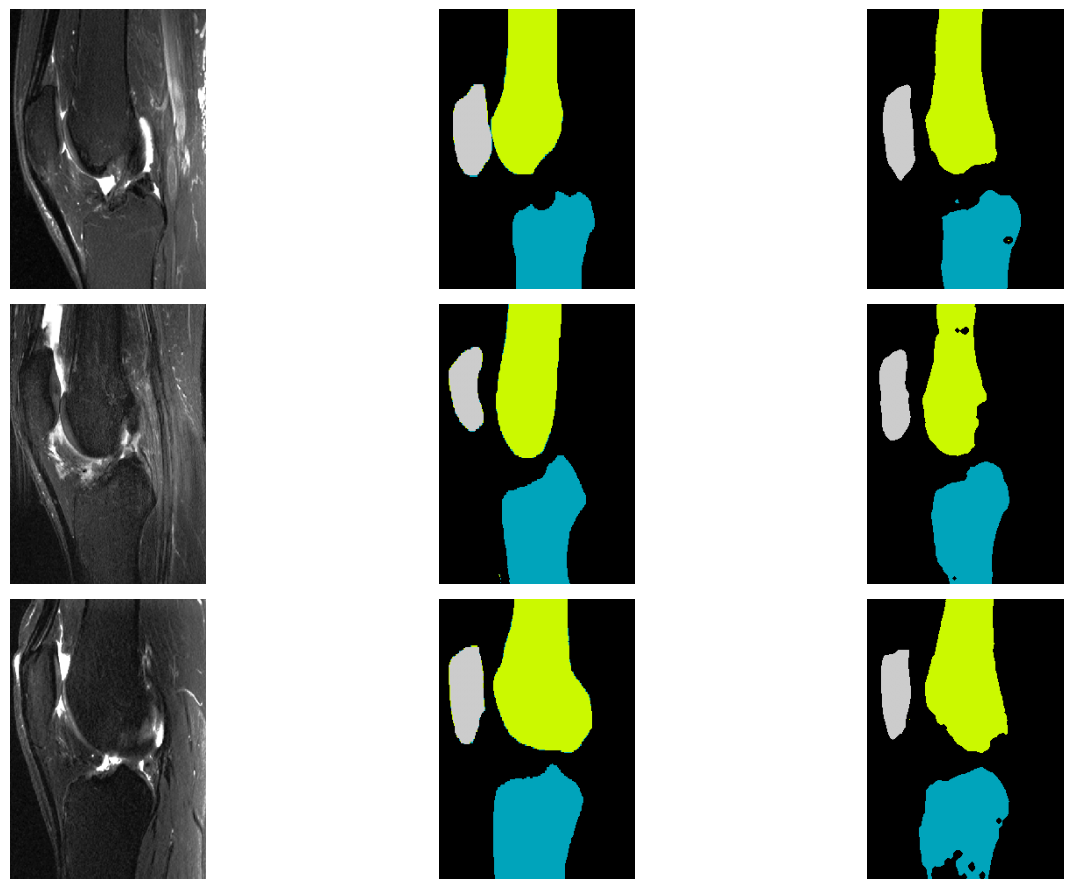

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# 1. Cargar el modelo
model_path = '/content/drive/MyDrive/Equipo Trifuerza/Códigos fuentes/Modelos entrenados/U-Net_entrenada_DA_45e_GPU.h5'
model = load_model(model_path)

# 2. Preparar muestras
num_samples   = 3
sample_images = images_val[:num_samples]            # ya normalizadas
sample_masks  = masks_val[:num_samples]
true_classes  = np.squeeze(sample_masks)            # (5, H, W)

# 3. Inferencia
preds = model.predict(sample_images)
preds_classes = np.argmax(preds, axis=-1)           # (5, H, W)

# 4. Post-procesado morfológico
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
preds_eroded = []
for pc in preds_classes:
    eroded_label = np.zeros_like(pc, dtype=np.uint8)
    for lbl in [1, 2, 3]:
        bin_mask = (pc == lbl).astype(np.uint8) * 255
        eroded = cv2.erode(bin_mask, kernel, iterations=2)
        eroded_label[eroded > 0] = lbl
    preds_eroded.append(eroded_label)
preds_eroded = np.stack(preds_eroded, axis=0)

# 5. Visualización
plt.figure(figsize=(15, num_samples * 3))
for i in range(num_samples):
    plt.subplot(num_samples, 3, i*3 + 1)
    plt.imshow(sample_images[i].squeeze(), cmap='gray')
    plt.axis('off')
    plt.subplot(num_samples, 3, i*3 + 2)
    plt.imshow(true_classes[i], cmap='nipy_spectral',
               vmin=0, vmax=NUM_CLASSES-1)
    plt.axis('off')
    plt.subplot(num_samples, 3, i*3 + 3)
    plt.imshow(preds_eroded[i], cmap='nipy_spectral',
               vmin=0, vmax=NUM_CLASSES-1)
    plt.axis('off')
plt.tight_layout()
plt.show()


Visualización


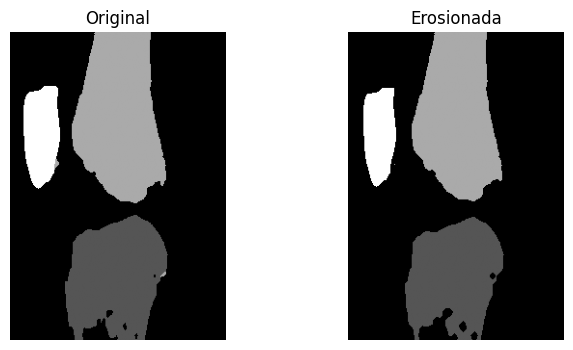

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
axs[0].imshow(pc, cmap='gray');        axs[0].set_title('Original');  axs[0].axis('off')
axs[1].imshow(eroded_label, cmap='gray'); axs[1].set_title('Erosionada'); axs[1].axis('off')
plt.show()

##Obtención de centroides

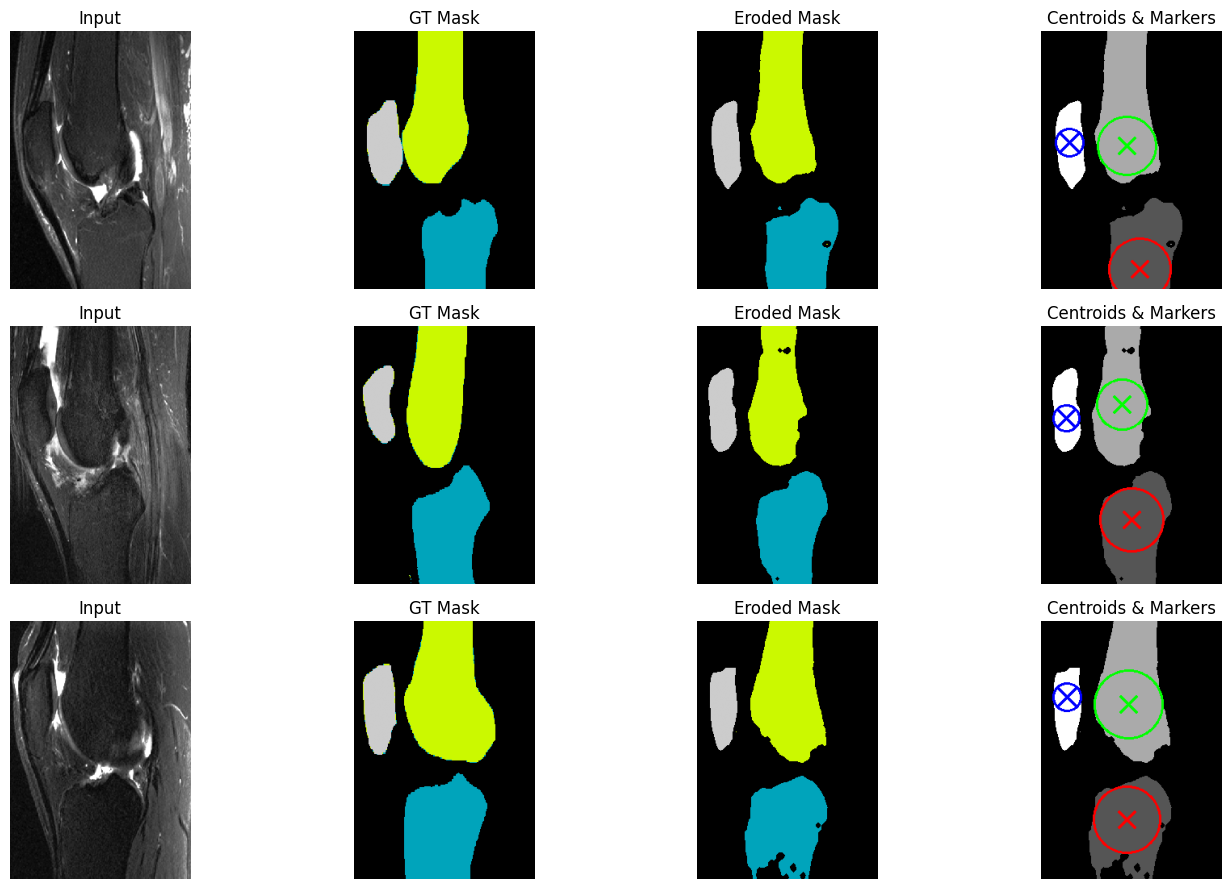

In [56]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

num_samples = preds_eroded.shape[0]

# Colores BGR para cada hueso
label_colors = {
    1: (0,   0, 255),   # fémur → rojo
    2: (0, 255,   0),   # tibia → verde
    3: (255, 0,   0),   # rótula → azul
}

plt.figure(figsize=(15, num_samples * 3))

for i in range(num_samples):
    img     = sample_images[i].squeeze()   # escala de grises
    true_m  = true_classes[i]
    er_mask = preds_eroded[i]              # (H, W) con etiquetas 0–3

    # — Subplot 1: input
    plt.subplot(num_samples, 4, i*4 + 1)
    plt.imshow(img, cmap='gray')
    plt.axis('off'); plt.title('Input')

    # — Subplot 2: ground-truth
    plt.subplot(num_samples, 4, i*4 + 2)
    plt.imshow(true_m, cmap='nipy_spectral',
               vmin=0, vmax=NUM_CLASSES-1)
    plt.axis('off'); plt.title('GT Mask')

    # Preparamos la imagen BGR para dibujar círculos y cruces
    vis = cv2.cvtColor(
        (er_mask * (255/(NUM_CLASSES-1))).astype(np.uint8),
        cv2.COLOR_GRAY2BGR
    )

    # Para cada etiqueta calculamos núcleo y centroides
    for lbl, color in label_colors.items():
        bin_mask = (er_mask == lbl).astype(np.uint8)
        if bin_mask.sum() == 0:
            continue

        # Distance transform para hallar el punto más interior
        dt = cv2.distanceTransform(bin_mask, cv2.DIST_L2, 5)
        _, maxVal, _, maxLoc = cv2.minMaxLoc(dt)
        cx, cy  = maxLoc
        radius  = int(maxVal)

        # Dibujar círculo
        cv2.circle(vis, (cx, cy), radius,
                   color=color, thickness=2)

        # Dibujar la “X” en el centro
        cv2.drawMarker(vis, (cx, cy),
                       color=color,
                       markerType=cv2.MARKER_TILTED_CROSS,
                       markerSize=20,
                       thickness=2)

    # — Subplot 3: máscara erosionada
    plt.subplot(num_samples, 4, i*4 + 3)
    plt.imshow(er_mask, cmap='nipy_spectral',
               vmin=0, vmax=NUM_CLASSES-1)
    plt.axis('off'); plt.title('Eroded Mask')

    # — Subplot 4: visualización final con círculos y cruces
    plt.subplot(num_samples, 4, i*4 + 4)
    plt.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))
    plt.axis('off'); plt.title('Centroids & Markers')

plt.tight_layout()
plt.show()


##Calculo del angulo Q